Title: Generate images using KerasCV's StableDiffusion's at unprecedented speeds
Author: [lukewood](https://lukewood.xyz), [fchollet](https://github.com/fchollet), [ianstenbit](https://github.com/ianstenbit)
Date created: 2022/24/09
Last modified: 2022/24/09
Description:

## Overview

In this guide, we will show how to generate novel images based on a text prompt using
the KerasCV implementation of [stability.ai's](https://stability.ai/) image to text
model,
[StableDiffusion](https://github.com/CompVis/stable-diffusion).

StableDiffusion is a powerful, open-source text to image generation model.  While there
exist numerous open source implementations that allow you to easily create images from
textual prompts, KerasCV's offers a few distinct advantages.
These include [XLA compilation](https://www.tensorflow.org/xla) and
[mixed precision computation](https://www.tensorflow.org/guide/mixed_precision).

In this guide, we will explore KerasCV's StableDiffusion implementation, show how to use
these powerful performance boosts, and explore the performance benefits
that they offer.

To get started, lets sort out some imports:

In [1]:
import keras_cv
from luketils import visualization
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import mixed_precision

## Introduction

Unlike most tutorials, where we first explain a topic then show how to implement it,
with text to image generation it is easiest to show instead of tell.

Check out the power of `keras_cv.models.StableDiffusion()`:

In [6]:
stable_diffusion = keras_cv.models.StableDiffusion()

In [2]:
def visualize_prompt(prompt, sd_model=None):
    sd_model = sd_model or stable_diffusion
    visualization.plot_gallery(
        sd_model.text_to_image(prompt, batch_size=3),
        rows=1, cols=3,
        scale=4,
        value_range=(0, 255),
        show=True
    )

25/25 [==============================] - 61s 2s/step


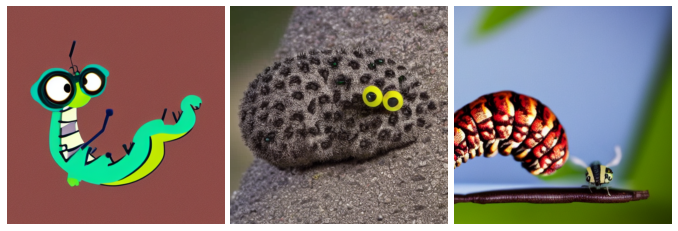

In [18]:
visualize_prompt("a cartoon caterpillar wearing glasses")

Pretty incredible!  

That's not all this model can do.  
Below are an assortment of prompts to spark your imagination as to what this model is capable of:

25/25 [==============================] - 61s 2s/step


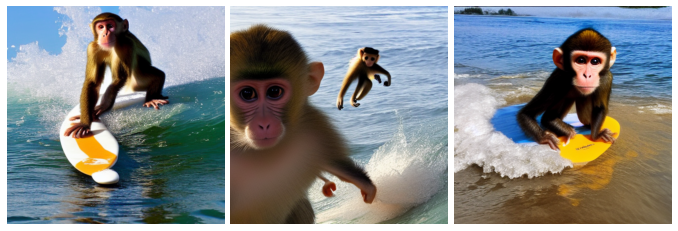

In [15]:
visualize_prompt(
    "The worlds cutest monkey surfing on a "
    "beautiful wave in the sunshine!"
)

25/25 [==============================] - 61s 2s/step


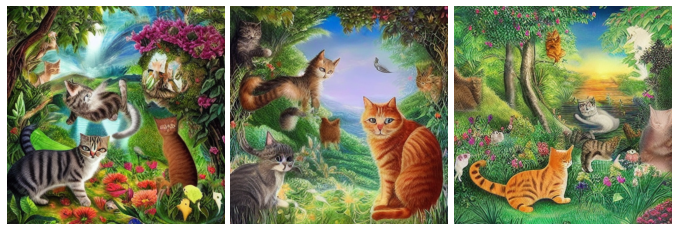

In [19]:
visualize_prompt(
    "Absolutely stunning artwork of the garden of eden, "
    "but filled with cats!"
)

25/25 [==============================] - 61s 2s/step


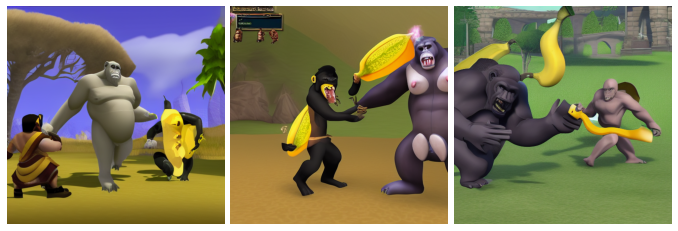

In [20]:
visualize_prompt(
    "Runescape character attacking a gorilla with a HUGE banana"
)

You can even provide an art style!

25/25 [==============================] - 61s 2s/step


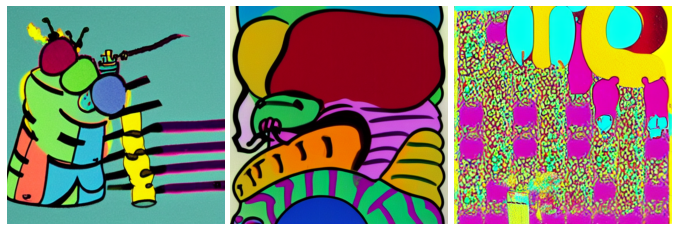

In [21]:
visualize_prompt(
    "a cute magical flying dog, fantasy art drawn by disney concept artists, "
    "golden colour, high quality, highly detailed, elegant, sharp focus, "
    "concept art, character concepts, digital painting, mystery, adventure"
)

The possibilities are literally endless (or as you will learn later: at least extend to the boundaries of StableDiffusion's latent manifold).

Pretty incredible!  The idea should be self evident at this point.
Now lets take a step back and look at how this algorithm actually works.

## The StableDiffusion Algorithm

TODO(lukewood): write this

## Perks of KerasCV

So, with numerous implementations of StableDiffusion publicly available why shoud you use `keras_cv.models.StableDiffusion()`?

Aside from the easy-to-use API, KerasCV's StableDiffusion model comes with some nice bells and trinkets.  These extra features include but are not limited to:

- out of the box support for XLA compilation
- support for `mixed_precision`
- ...

When these are combined, the KerasCV StableDiffusion model runs orders of magnitude faster than naive implementations.  This section shows how to enable all of these features, and the resulting performance gain yielded from using them.

**Note: The difference between the performance benefits from each optimization vary drastically between hardware**


### XLA Compilation

TensorFlow comes with the [XLA: Accelerated Linear Algebra](https://www.tensorflow.org/xla) compiler built in.
`keras_cv.models.StableDiffusion` supports a `jit_compile` argument out of the box.  
Setting this argument to `True` enables XLA compilation; resulting in a significant speed-up.

Lets use this below.

In [4]:
import time
class Timer:
    def __init__(self):
        self.start_time = None
        self.end_time = None

    def __enter__(self):
        self.start_time = time.perf_counter()
        return self

    def __exit__(self, exc_type, exc_value, exc_traceback):
        self.end_time = time.perf_counter()

    @property
    def result(self):
        if self.start_time is None or self.end_time is None:
            raise RuntimeError(
                "Attempting to use timer before timing context is exited."
            )
        return self.end_time - self.start_time
ez_timer = Timer

25/25 [==============================] - 31s 245ms/step


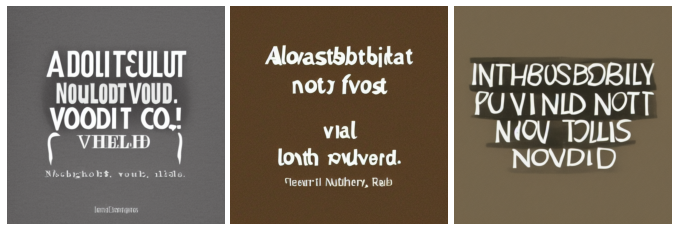

In [12]:
tf.keras.backend.clear_session()
xla_stable_diffusion = keras_cv.models.StableDiffusion(jit_compile=True)

25/25 [==============================] - 6s 244ms/step


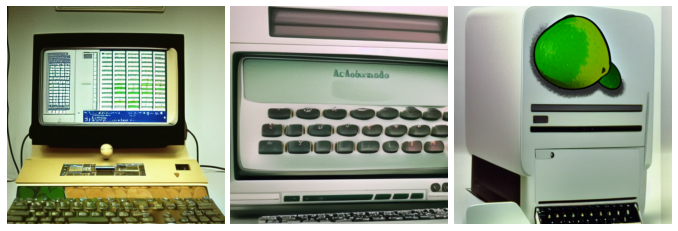

In [16]:
# warm up the model by running inference once before timing it
visualize_prompt(
    "An oldschool macintosh computer showing an avocado on its screen",
    sd_model=xla_stable_diffusion
)

25/25 [==============================] - 23s 319ms/step


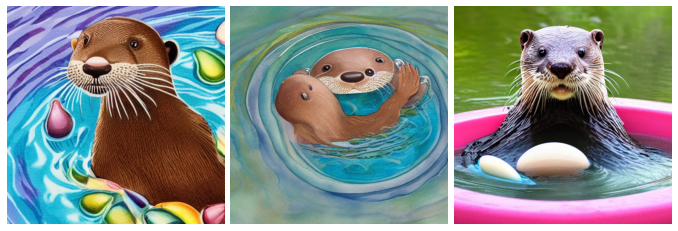

Without XLA took 35.47210497799995 seconds


In [8]:
with ez_timer() as timer:
    visualize_prompt(
        "A cute water-colored otter in a rainbow whirlpool holding shells",
        sd_model=stable_diffusion
    )
print(f"Without XLA took {timer.result} seconds")

25/25 [==============================] - 6s 244ms/step


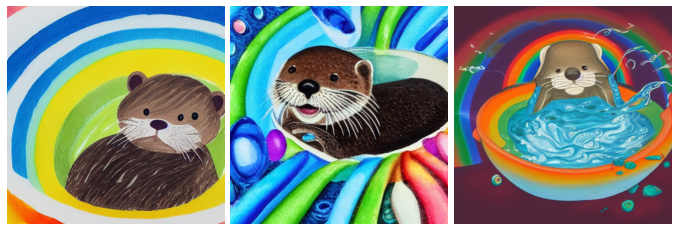

With XLA took 6.525567480000063 seconds


In [13]:
with ez_timer() as timer:
    visualize_prompt(
        "A cute water-colored otter in a rainbow whirlpool holding shells",
        sd_model=xla_stable_diffusion
    )
print(f"With XLA took {timer.result} seconds")

### Mixed Precision

Mixed precision computation is the process of mixing `float32` and `float16` precision dtypes to take advantage of the fact that `float16` operations are significantly faster on modern accelarators.

While a low-level setting, enabling mixed precision computation in Keras (and therefore for `keras_cv.models.StableDiffusion`) is as simple as calling:

First, lets benchmark again without mixed precision:

25/25 [==============================] - 8s 313ms/step


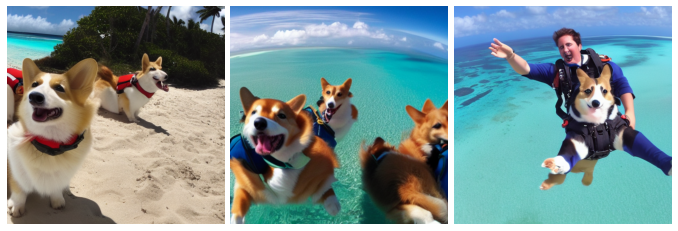

Without mixed precision took 8.409495428000128 seconds


In [8]:
with ez_timer() as timer:
    visualize_prompt(
        "a cute magical flying dog, fantasy art drawn by disney concept artists, "
        "golden colour, high quality, highly detailed, elegant, sharp focus, "
        "concept art, character concepts, digital painting, mystery, adventure",
        sd_model=stable_diffusion
    )
print(f"Without mixed precision took {timer.result} seconds")

In [9]:
mixed_precision.set_global_policy('mixed_float16')

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA A100-SXM4-40GB, compute capability 8.0


That's all.  It just works.

In [10]:
tf.keras.backend.clear_session()
stable_diffusion_mixed_precision = keras_cv.models.StableDiffusion()
print('Old compute dtype:', stable_diffusion.diffusion_model.compute_dtype)
print('Old variable dtype:', stable_diffusion.diffusion_model.variable_dtype)
print('New compute dtype:', stable_diffusion_mixed_precision.diffusion_model.compute_dtype)
print('New variable dtype:', stable_diffusion_mixed_precision.diffusion_model.variable_dtype)

Old compute dtype: float32
Old variable dtype: float32
New compute dtype: float16
New variable dtype: float32


As you can see, the model constructed above now uses mixed precision computation; leveraging the speed of `float16` for computation, and `float32` to store variables.

In [ ]:
stable_diffusion_mixed_precision.text_to_image('warming up the model')

25/25 [==============================] - 4s 152ms/step


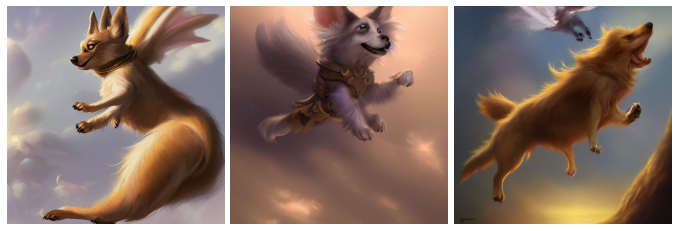

With mixed precision took 4.3493777130001945 seconds


In [12]:
with ez_timer() as timer:
    visualize_prompt(
        "a cute magical flying dog, fantasy art drawn by disney concept artists, "
        "golden colour, high quality, highly detailed, elegant, sharp focus, "
        "concept art, character concepts, digital painting, mystery, adventure",
        sd_model=stable_diffusion_mixed_precision
    )
print(f"With mixed precision took {timer.result} seconds")

## Putting It All Together

So?  How do you assemble the world's most performant stable diffusion inference pipeline (as of September 2022).

Two lines of code:

In [14]:
mixed_precision.set_global_policy('mixed_float16')
supermodel = keras_cv.models.StableDiffusion(jit_compile=True)
supermodel.text_to_image('warming up the model')

and how fast is it?

25/25 [==============================] - 4s 153ms/step


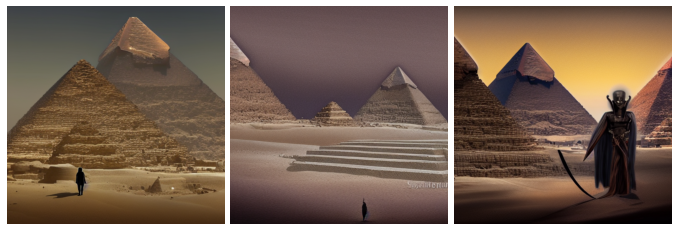

With XLA and mixed precision took 4.367918060000193 seconds


In [25]:
with ez_timer() as timer:
    visualize_prompt(
        "A mysterious dark stranger visits the great pyramids of egypt, "
        "high quality, highly detailed, elegant, sharp focus, "
        "concept art, character concepts, digital painting",
        sd_model=supermodel
    )
print(f"With XLA and mixed precision took {timer.result} seconds")

Four seconds to generate three novel images from a text prompt.

What a time to be alive!

## Engineering Good Prompts

You may notice above that some of the prompts have descriptors such as:
```
"high quality, highly detailed, elegant, sharp focus, "
"concept art, character concepts, digital painting",
```

Why is this?

TODO(ianstenbit): Some help would be great

## Benchmarks

@ianstenbit can write this

## Conclusions

KerasCV offers a high quality API to leverage StableDiffusion today.  
Through the use of XLA and mixed precision Tensorflow allows us to construct the fastest StableDiffusion pipeline available as of September 2022.

Normally, at the end of a keras.io tutorial we leave you with some future directions to continue in to learn.
This time, we leave you with one idea: 

**Go run your own prompts through the model!  It is an absolute blast!**